# CIFAR Code - Resnet
The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck



In [0]:
# loading all necessay packages for visualization.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [33]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create loaders

In [0]:
torch.manual_seed(101)  # just in cse anyone wants to reproduce the results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [0]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

We don't want to use the variable name "class" here, as it would overwrite Python's built-in keyword.

## View a batch of images

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


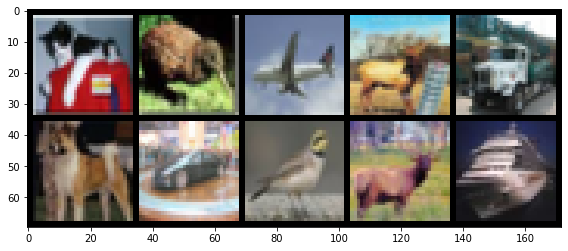

In [36]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Model with best accuracy:- Resnet 18 trained for 100 epochs.
### Number of parameters:- 265050
### Augmentations:- Random crop, random flip, normalized tensors with the use of the mean and standard  deviation for RGB channels of the "cifar10" dataset. Other augmentations decreased the                               testing accuracy (please refer to the excel file).
### Testing accuracy obtained:- 

In [48]:
#Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os

#Basic block of our residual network. Each block consists two convolutions and the shortcut is a simple downsampling convolutional operation.
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
#The forward pass 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

#We define a bottleneck architecture as the type found in the ResNet paper where [two 3x3 conv layers] are replaced by [one 1x1 conv, one 3x3 conv, and another 1x1 conv layer].
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

#The residual network architecture.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    #Defining the forward pass
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

"""
ResNet18():ResNet(BasicBlock, [2,2,2,2])

ResNet34():ResNet(BasicBlock, [3,4,6,3])

ResNet50():ResNet(Bottleneck, [3,4,6,3])

ResNet101():ResNet(Bottleneck, [3,4,23,3])

ResNet152():ResNet(Bottleneck, [3,8,36,3])
""" 
    

#-------------------------------------------------------------------------------



device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5, resample=False, expand=False, center=None, fill=0),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([                                 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')

net = ResNet(BasicBlock, [2,2,2,2])
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Training function that optimizes the weights during a batch; it also calculates training accuracy.
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f'Training accuracy for epoch {epoch}:{100*(correct/total)}')

        
#Testing function that freezes the weights and calculates the testing accuracy once an epoch is over.
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f'Testing accuracy for epoch {epoch}:{100*(correct/total)}')

            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)
print('\n')
print(f'The best test accuracy obtained is :{best_acc}')

==> Preparing data..
ERROR! Session/line number was not unique in database. History logging moved to new session 59
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
Training accuracy for epoch 0:37.518
Testing accuracy for epoch 0:50.21
Saving..

Epoch: 1
Training accuracy for epoch 1:54.215999999999994
Testing accuracy for epoch 1:56.34
Saving..

Epoch: 2
Training accuracy for epoch 2:61.536
Testing accuracy for epoch 2:66.72
Saving..

Epoch: 3
Training accuracy for epoch 3:66.108
Testing accuracy for epoch 3:69.67999999999999
Saving..

Epoch: 4
Training accuracy for epoch 4:69.226
Testing accuracy for epoch 4:70.56
Saving..

Epoch: 5
Training accuracy for epoch 5:71.868
Testing accuracy for epoch 5:73.37
Saving..

Epoch: 6
Training accuracy for epoch 6:74.31400000000001
Testing accuracy for epoch 6:72.43

Epoch: 7
Training accuracy for epoch 7:76.23400000000001
Testing accuracy for epoch 7:77.5
Saving..

Epoch: 8
Training accu

### The End. Thank You!